# Анализ отзывов IMDB с библиотеками *scikit-learn* и *nltk*

Создадим линейный классификатор, который будет с точностью не менее 95% определять негативные отзывы к фильмам. То есть задача состоит в нахождении такого порога вероятности отнесения наблюдения к положительному классу, при котором метрика **negative predictive value (NPV)** будет иметь значение не менее 0.95. После этого оценим некоторые другие метрики модели.

[Датасет](http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz) с подробным описанием.

Импортируем все необходимые модули, функции и классы.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

Загружаем тренировочный и тестовый датасеты и сразу выделяем признаки и целевую переменную для каждого датасета.
Для тренировочного датасета необходимо явно указать названия папок с отзывами, т.к. иначе *load_files* загрузит в трейн ещё и содержимое папки **unsup**.

In [2]:
reviews_train = load_files('Путь до папки train', categories=['pos', 'neg'])
X_train, y_train = reviews_train.data, reviews_train.target

In [3]:
print(f'Количество документов в тренировочном датасете: {len(X_train)}')

Количество документов в тренировочном датасете: 25000


In [4]:
reviews_test = load_files('Путь до папки test')
X_test, y_test = reviews_test.data, reviews_test.target

In [5]:
print(f'Количество документов в тестовом датасете: {len(X_test)}')

Количество документов в тестовом датасете: 25000


Реализуем токенайзер, который будет удалять из токенов знаки пунктуации, стоп-слова и производить стемминг.

In [6]:
snowball = SnowballStemmer(language='english')
stop_words = stopwords.words('english')

def tokenize_sentence(sentence: str, remove_stop_words: bool=True):
    tokens = word_tokenize(sentence, language='english')
    tokens = [i for i in tokens if i not in string.punctuation]
    if remove_stop_words:
        tokens = [i for i in tokens if i not in stop_words]
    tokens = [snowball.stem(i) for i in tokens]
    return tokens

Напишем универсальную функцию для расчёта метрик, которые нам понадобятся, а также для расчёта матрицы ошибок.

In [7]:
def get_score(y_true: np.array, y_pred_proba: np.array, score: str='npv', threshold: np.float32=0.5):
    y_pred = (y_pred_proba >= threshold).astype(np.int8)
    tp, tn, fp, fn = .0, .0, .0, .0
    for i, label in enumerate(y_true):
        if label==y_pred[i] and label==1:
            tp += 1
        if label==y_pred[i] and label==0:
            tn += 1
        if label!=y_pred[i] and label==1:
            fn += 1
        if label!=y_pred[i] and label==0:
            fp += 1
    if score=='npv':
        return tn/(tn+fn)
    elif score=='specificity':
        return tn/(tn+fp)
    elif score=='confusion_matrix':
        return [[tp, fp], [fn, tn]]
    else:
        raise ValueError('Incorrect metric to calculate')

Преобразуем текст в TF-IDF представление. Для *TfidfVectorizer*'а переопределяем токенайзер на наш.

In [8]:
vectorizer = TfidfVectorizer(tokenizer=tokenize_sentence).fit(X_train)
X_train_tfidf = vectorizer.transform(X_train)

c:\users\opens\appdata\local\programs\python\python39\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


Найдём модель с оптимальным коэффициентом регуляризации с помощью кросс-валидации. Валидироваться будем по метрике **NPV**.

In [9]:
skf = StratifiedKFold(shuffle=True, random_state=42)

grid_logit = GridSearchCV(LogisticRegression(max_iter=1000, n_jobs=-1), dict(C=[0.1, 1, 10, 20, 50, 100]),
                         scoring=make_scorer(get_score, needs_proba=True), cv=skf, return_train_score=True)
grid_logit.fit(X_train_tfidf, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(max_iter=1000, n_jobs=-1),
             param_grid={'C': [0.1, 1, 10, 20, 50, 100]},
             return_train_score=True,
             scoring=make_scorer(get_score, needs_proba=True))

Построим кривую валидации.

In [10]:
def plot_validation_curve(grid):
    res = grid.cv_results_
    for mean, label in [['mean_train_score', 'Train'], ['mean_test_score', 'Test']]:
        plt.plot(np.array([i.get('C') for i in res['params']]), res[mean], label=label, linewidth=3)
    plt.legend(fontsize=20, loc=5)
    plt.xlabel('C', fontsize=20)
    plt.ylabel('NPV', fontsize=20)
    sns.set(rc={'font.size': 20, 'xtick.labelsize': 'medium', 'ytick.labelsize': 'medium', 'figure.figsize': (10, 8),
                'xtick.labeltop': False, 'xtick.labelbottom': True})
    plt.show()

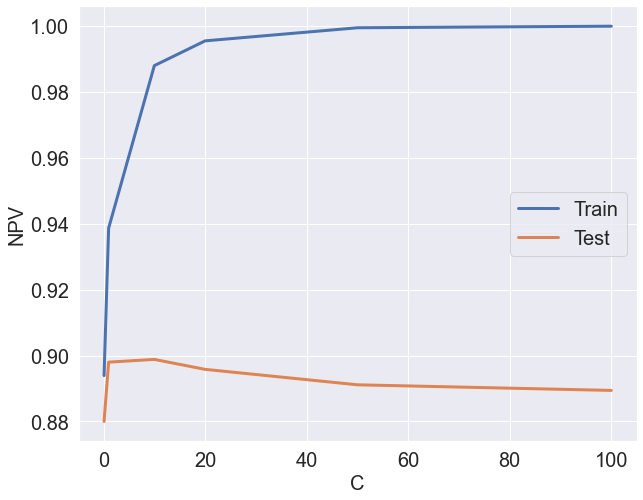

In [12]:
plot_validation_curve(grid_logit)

По кривой валидации видно, что модель переобучается, и для её оптимизации недостаточно только подобрать коэффициент регуляризации. Возможно, стоит изменить функцию регуляризации (параметр *penalty*), либо решающий алгоритм (параметр *solver*), либо вовсе взять за основу модели другой алгоритм.

Выберем такой коэффициент регуляризации, при котором разница между метрикой на трейне и на тесте как можно меньше, и при этом значение метрики на тесте должно быть как можно больше. В данном случае, возьмём *C=1*.

Напишем пайплайн с оптимальным коэффициентом регуляризации.

In [13]:
logit_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=tokenize_sentence)),
    ('logit', LogisticRegression(C=1, max_iter=1000, n_jobs=-1))
])
logit_pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function tokenize_sentence at 0x000002003216F700>)),
                ('logit', LogisticRegression(C=1, max_iter=1000, n_jobs=-1))])

Сохраним предсказанные вероятности модели в отдельную переменную (чтобы каждый раз снова не запускать этот достаточно долгий процесс).

In [14]:
probas = logit_pipe.predict_proba(X_test)[:, 1]

Вычислим **NPV** модели с базовым порогом вероятности отнесения наблюдения к положительному классу.

In [15]:
print(f'NPV модели с порогом p=0.5: {get_score(y_test, probas)}')

NPV модели с порогом p=0.5: 0.8811849479583667


Модель верно определяет негативный отзыв примерно в 88% случаев. Вычислим специфичность модели при том же пороге вероятности.

In [16]:
print(f'Специфичность модели с порогом p=0.5: {get_score(y_test, probas, score="specificity")}')

Специфичность модели с порогом p=0.5: 0.88048


Это значит, что модель обнаруживает примерно 88% всех негативных отзывов.

Попробуем увеличить точность модели на отрицательном классе (**NPV**), уменьшая порог вероятности.

In [17]:
thresholds = np.arange(0.1, 0.5, 0.01)
for p in thresholds:
    print(f'NPV модели с порогом p={p:.2f}: {get_score(y_test, probas, threshold=p)}')

NPV модели с порогом p=0.10: 0.9927716286424215
NPV модели с порогом p=0.11: 0.9920084121976867
NPV модели с порогом p=0.12: 0.9899408284023669
NPV модели с порогом p=0.13: 0.9895891429633761
NPV модели с порогом p=0.14: 0.988524011299435
NPV модели с порогом p=0.15: 0.9875021111298767
NPV модели с порогом p=0.16: 0.9844282238442822
NPV модели с порогом p=0.17: 0.9837980993924287
NPV модели с порогом p=0.18: 0.9823061928325086
NPV модели с порогом p=0.19: 0.9804035418783568
NPV модели с порогом p=0.20: 0.9789029535864979
NPV модели с порогом p=0.21: 0.9765041423332881
NPV модели с порогом p=0.22: 0.9747754886423666
NPV модели с порогом p=0.23: 0.9720261773386373
NPV модели с порогом p=0.24: 0.9710417450169236
NPV модели с порогом p=0.25: 0.9695673429479345
NPV модели с порогом p=0.26: 0.9665391969407265
NPV модели с порогом p=0.27: 0.9635769320569694
NPV модели с порогом p=0.28: 0.9615691641008097
NPV модели с порогом p=0.29: 0.9580583827312381
NPV модели с порогом p=0.30: 0.9568266491

Видим, что при пороге *p=0.32* и меньше **NPV** превышает 95%. Построим матрицу ошибок для данного порога.

In [18]:
def plot_confusion_matrix(y_true: np.array, y_pred_proba: np.array, threshold: np.float32=0.5):
    confusion_matrix = get_score(y_true, y_pred_proba, 'confusion_matrix', threshold)
    sns.heatmap(confusion_matrix, cmap='viridis', annot=confusion_matrix, cbar=False, fmt='n',
                     xticklabels=['y = 1', 'y = 0'], yticklabels=['ŷ = 1', 'ŷ = 0'])
    sns.set(rc={'font.size': 20, 'xtick.labelsize': 'medium', 'ytick.labelsize': 'medium', 'xtick.labeltop': True,
               'xtick.labelbottom': False, 'figure.figsize': (10, 8)})

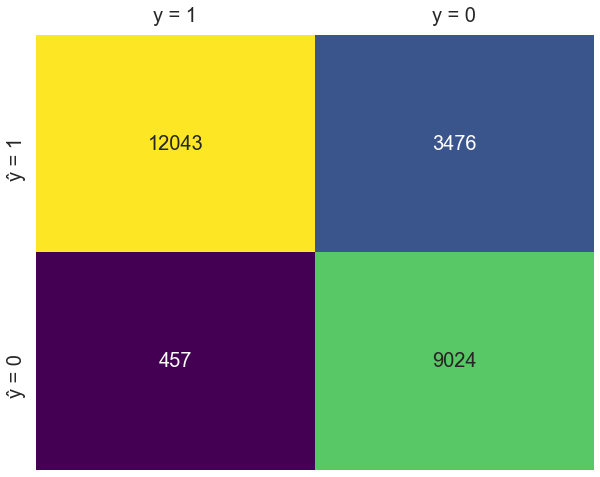

In [20]:
plot_confusion_matrix(y_test, probas, 0.32)

In [21]:
print(f'Специфичность модели с порогом p=0.32: {9024/(9024+3476)}')

Специфичность модели с порогом p=0.32: 0.72192


При высокой точности на отрицательном классе, модель обнаруживает примерно 72% всех негативных отзывов.

Посмотрим на метрики модели для положительного класса.

In [22]:
print(f'Точность модели на положительном классе (precision) с порогом p=0.32: {12043/(12043+3476)}')

Точность модели на положительном классе (precision) с порогом p=0.32: 0.7760164959082415


Модель верно определяет положительный отзыв примерно в 78% случаев.

In [23]:
print(f'Полнота модели (recall) с порогом p=0.32: {12043/(12043+457)}')

Полнота модели (recall) с порогом p=0.32: 0.96344


Модель находит примерно 96% всех положительных отзывов, однако этот показатель сам по себе (равно как и специфичность) не особо полезен, т.к. *precision* модели достаточно низок.

Изобразим наиболее "тяжеловесные" токены в датасете.

In [24]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    coefs = classifier.coef_.ravel()
    pos_coefs = np.argsort(coefs)[-n_top_features:]
    neg_coefs = np.argsort(coefs)[:n_top_features]
    coefs_to_show = np.hstack([neg_coefs, pos_coefs])
    colors = ['red' if i<0 else 'blue' for i in coefs[coefs_to_show]]
    plt.bar(np.arange(2*n_top_features), coefs[coefs_to_show], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 2*n_top_features+1), feature_names[coefs_to_show], rotation=60, ha='right')
    sns.set(rc={'font.size': 13, 'xtick.labelsize': 'medium', 'ytick.labelsize': 'medium', 'figure.figsize': (14, 10),
                'xtick.labeltop': False, 'xtick.labelbottom': True})

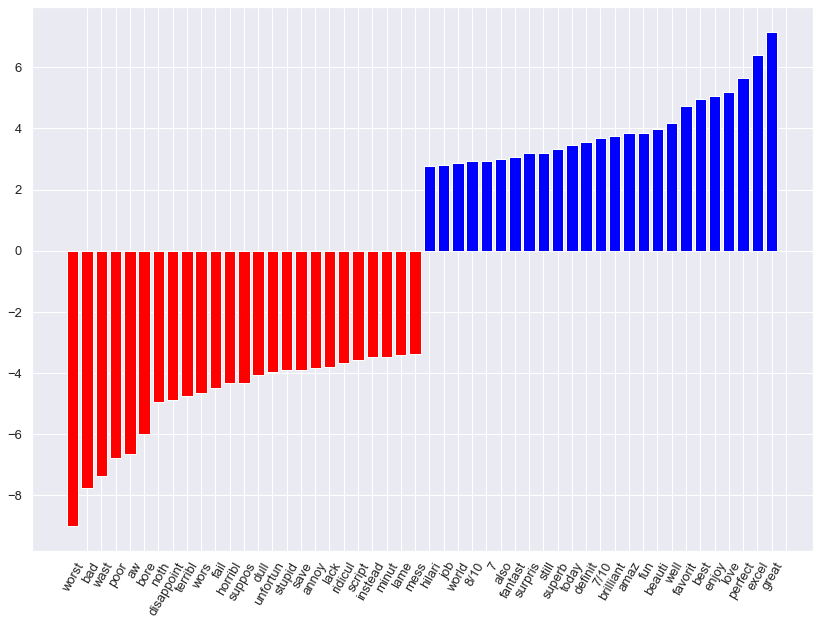

In [26]:
logit = LogisticRegression(C=1, max_iter=1000, n_jobs=-1).fit(X_train_tfidf, y_train)
visualize_coefficients(logit, vectorizer.get_feature_names())